<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Rio_Dengue_Risk_Classification_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [268]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import plotly.express as px


from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import Sequential

from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

from itertools import product
from tensorflow.keras.optimizers import Adam

from tqdm.auto import tqdm
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.utils import to_categorical


from statsmodels.tsa.stattools import ccf

from xgboost import XGBClassifier
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, confusion_matrix
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import GridSearchCV

In [269]:
def get_data(ibge, ey_start, ey_end):
  url = "https://info.dengue.mat.br/api/alertcity"
  geocode = ibge
  disease = "dengue"
  format = "csv"
  ew_start = 1
  ew_end = 53
  ey_start = ey_start
  ey_end = ey_end

  params =(
      "&disease="
      + f"{disease}"
      + "&geocode="
      + f"{geocode}"
      + "&disease="
      + f"{disease}"
      + "&format="
      + f"{format}"
      + "&ew_start="
      + f"{ew_start}"
      + "&ew_end="
      + f"{ew_end}"
      + "&ey_start="
      + f"{ey_start}"
      + "&ey_end="
      + f"{ey_end}"
  )

  url_resp = "?".join([url, params])
  dados = pd.read_csv(url_resp, index_col='SE')
  return dados

In [270]:
 # rio_neighbours_all = [3304557, 3302007, 3305554, 3303500,3301702, 3305109, 3300456, 3303203, 3302858, 3304144, 3302270, 3302858]
rio_neighbours = [3304557, 3302007, 3305554, 3303500, 3301702, 3305109, 3303203, 3302858]

In [271]:
# geojson_url = "https://raw.githubusercontent.com/tbrugz/geodata-br/master/geojson/geojs-100-mun.json"

# muni = gpd.read_file(geojson_url)
# muni["id"] = muni["id"].astype(str)

# rio = muni[muni["id"].str.startswith("330")].copy() # Municipality rio ibge starts with 330
# ribge = [str(x).zfill(7) for x in rio_neighbours]

# rpl = pd.DataFrame({"ibge": rio["id"]})
# rpl["selected"] = "other"
# rpl.loc[rpl["ibge"].isin(ribge), "selected"] = "neighbour"
# rpl.loc[rpl["ibge"] == "3304557", "selected"] = "rio_city"

# fig = px.choropleth(
#     rpl,
#     geojson=rio.__geo_interface__,
#     locations="ibge",
#     featureidkey="properties.id",
#     color="selected",
#     color_discrete_map={
#         "other":   "lightgrey",
#         "neighbour": "orange",
#         "rio_city": "maroon",
#     }
# )

# fig.update_traces(marker_line_width=0.4, marker_line_color="black")
# fig.update_geos(fitbounds="locations", visible=False)
# fig.update_layout(margin=dict(l=0, r=0, t=0, b=0), coloraxis_showscale=False)

# fig.show()


In [272]:
rj = []
for i, ibge in enumerate(rio_neighbours):
    data = get_data(ibge=ibge, ey_start=2010, ey_end=2025)
    data['region'] = f"r{i+1}"
    rj.append(data)

all = pd.concat(rj, ignore_index=True)

In [273]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [274]:
all.head(5)

,data_iniSE,casos_est,casos_est_min,casos_est_max,casos,p_rt1,p_inc100k,Localidade_id,nivel,id,...,umidmin,tempmed,tempmax,casprov,casprov_est,casprov_est_min,casprov_est_max,casconf,notif_accum_year,region
0,2025-09-28,309.0,199,544.0,118,0.549897,4.663553,0,1,330455720254020368,...,41.754125,22.025125,28.983125,67.0,NaN,NaN,NaN,NaN,665981,r1
1,2025-09-21,301.0,269,353.0,239,0.605514,4.542814,0,1,330455720253920368,...,48.662471,21.936329,26.060614,89.0,NaN,NaN,NaN,NaN,665981,r1
2,2025-09-14,324.0,309,345.0,293,0.959198,4.889939,0,1,330455720253820368,...,49.199000,22.083943,27.310429,98.0,NaN,NaN,NaN,NaN,665981,r1
3,2025-09-07,293.0,282,307.0,274,0.705604,4.422075,0,1,330455720253720368,...,56.739414,21.020400,24.826800,101.0,NaN,NaN,NaN,NaN,665981,r1
4,2025-08-31,278.0,270,289.0,264,0.322483,4.195689,0,1,330455720253620368,...,48.862986,21.417529,26.341886,74.0,NaN,NaN,NaN,NaN,665981,r1


## Data Exploration

Because I want to learn how to predict the nivel, and the source uses
1. Weather
2. Twitter
3. Reported Cases

In [275]:
all.columns

Index(['data_iniSE', 'casos_est', 'casos_est_min', 'casos_est_max', 'casos',
       'p_rt1', 'p_inc100k', 'Localidade_id', 'nivel', 'id', 'versao_modelo',
       'tweet', 'Rt', 'pop', 'tempmin', 'umidmax', 'receptivo', 'transmissao',
       'nivel_inc', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'casprov',
       'casprov_est', 'casprov_est_min', 'casprov_est_max', 'casconf',
       'notif_accum_year', 'region'],
      dtype='object')

In [276]:
cols = ['data_iniSE', 'nivel','p_inc100k', 'tweet', 'Rt', 'p_rt1', 'tempmin', 'umidmax', 'umidmed', 'umidmin', 'tempmed', 'tempmax', 'region']
all_filt = all[cols].copy()

In [277]:
all_filt.isna().sum()

,0
data_iniSE,0
nivel,0
p_inc100k,0
tweet,952
Rt,0
p_rt1,0
tempmin,0
umidmax,150
umidmed,150
umidmin,150


In [278]:
def plot_ts(df, cols, date_col="data_iniSE", region_col="region", na_fill=0):

    df = df.copy()
    if not pd.api.types.is_datetime64_any_dtype(df[date_col]):
        df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

    df[cols] = df[cols].fillna(na_fill)

    regions = df[region_col].unique()

    for col in cols:
        plt.figure(figsize=(17, 5))
        for r in regions:
            g = df[df[region_col] == r].sort_values(date_col)
            plt.plot(g[date_col], g[col], marker='o', markersize=2, label=f"Region {r}")
        plt.title(col)
        plt.xlabel("Date")
        plt.ylabel(col)
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


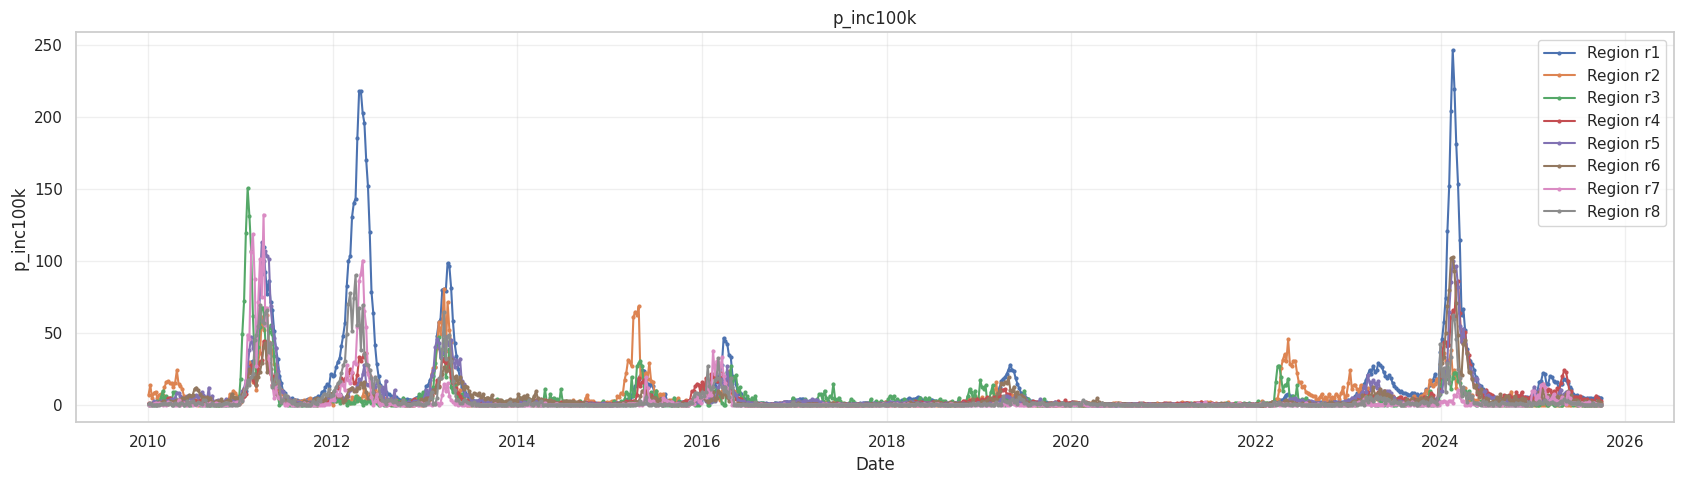

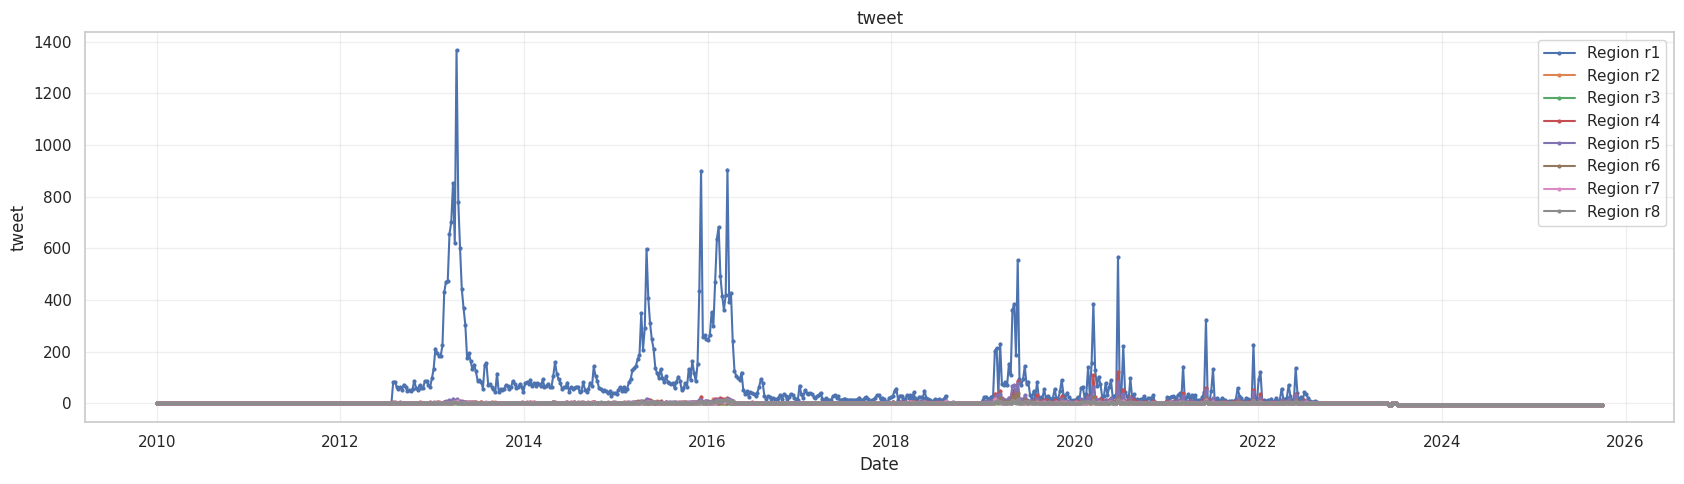

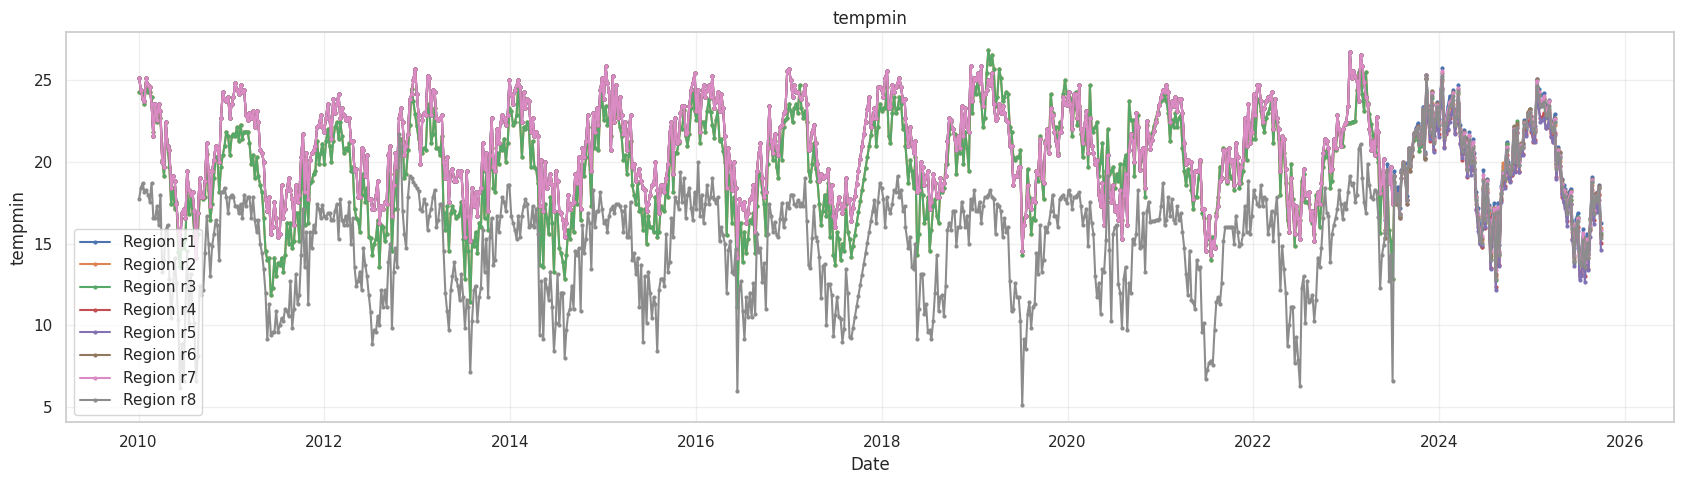

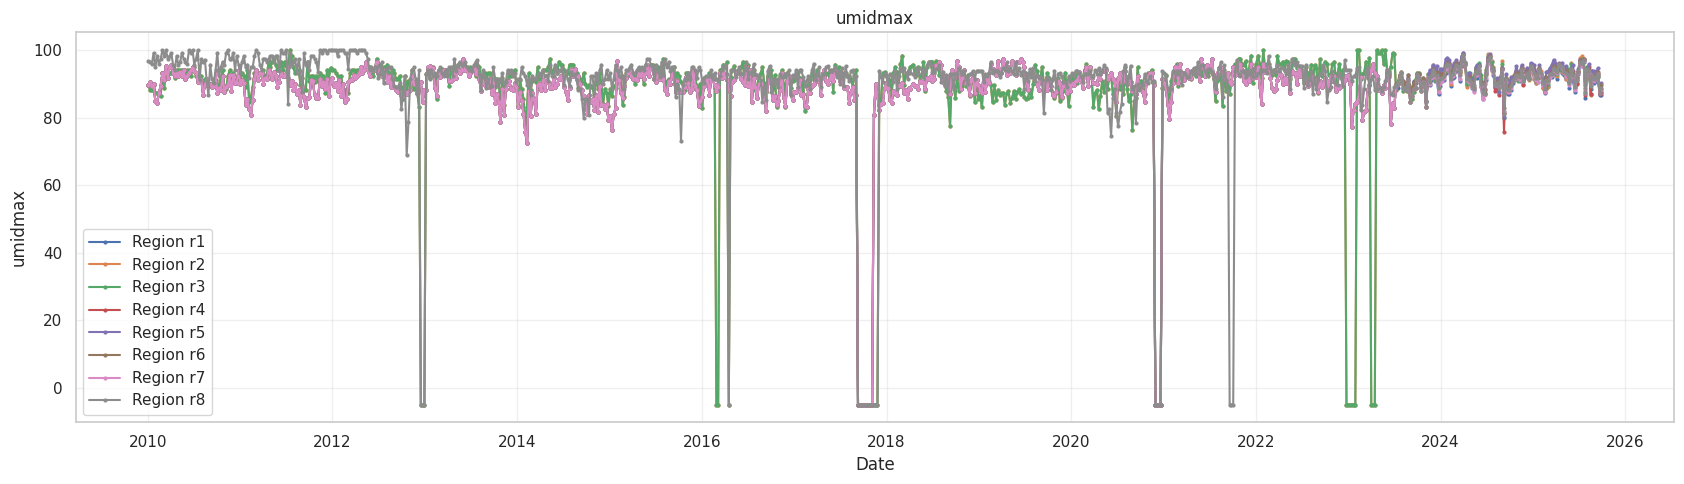

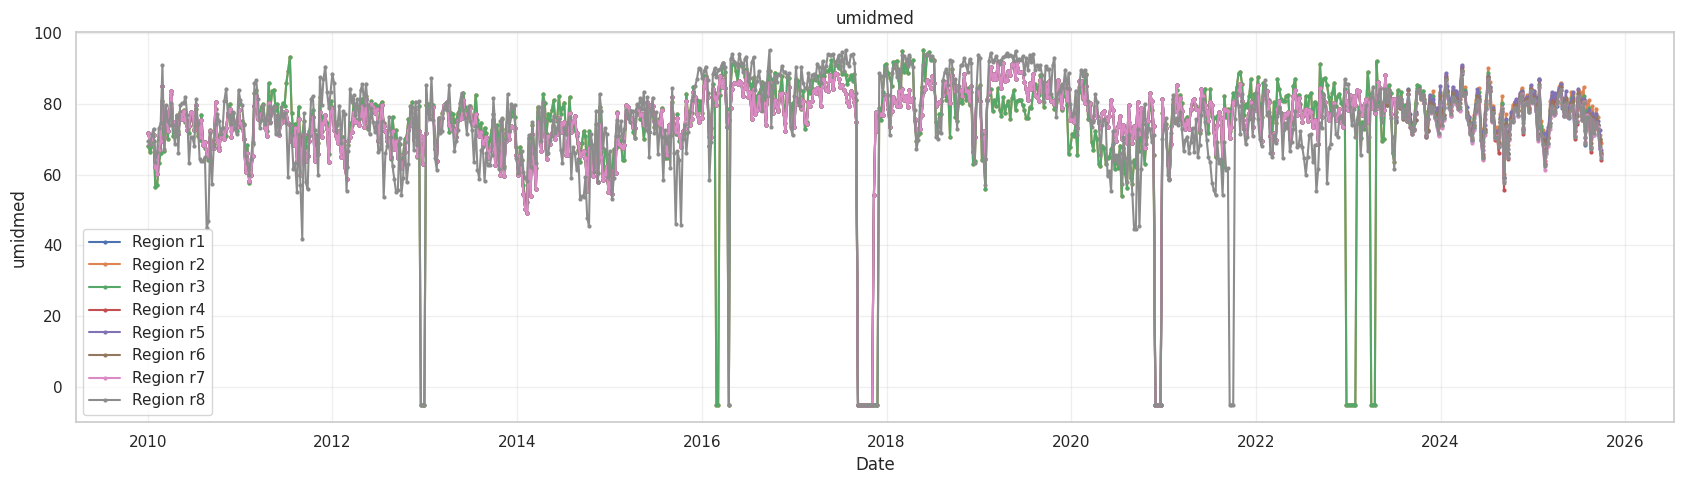

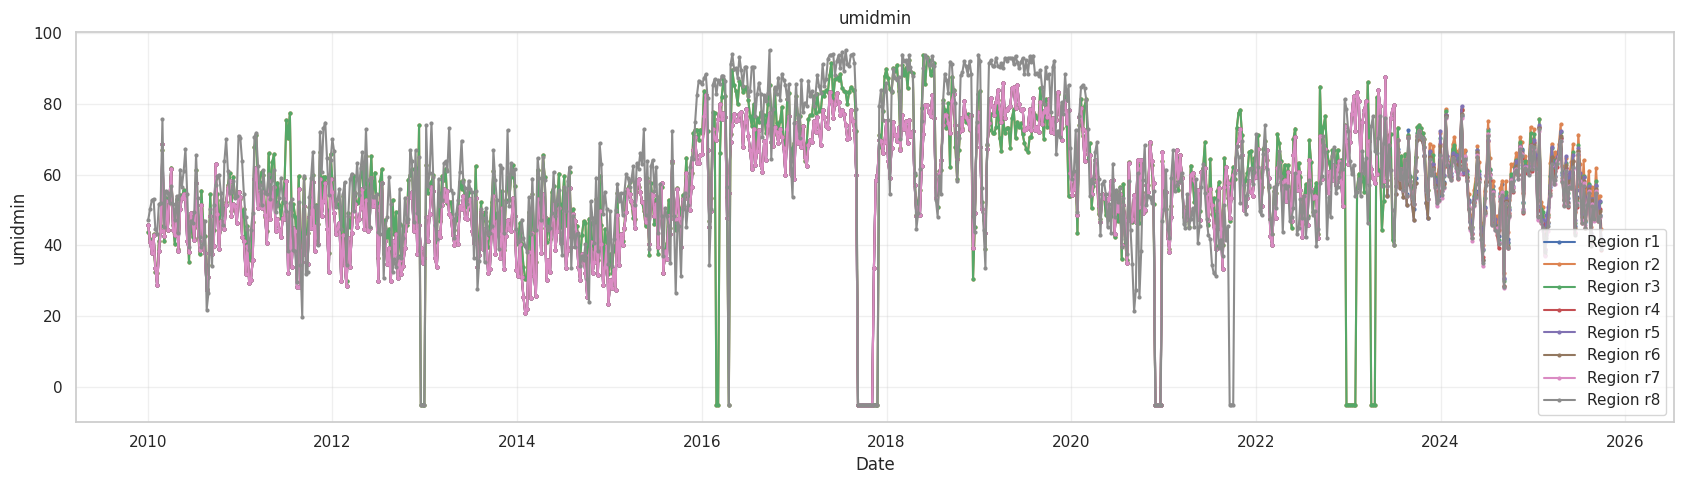

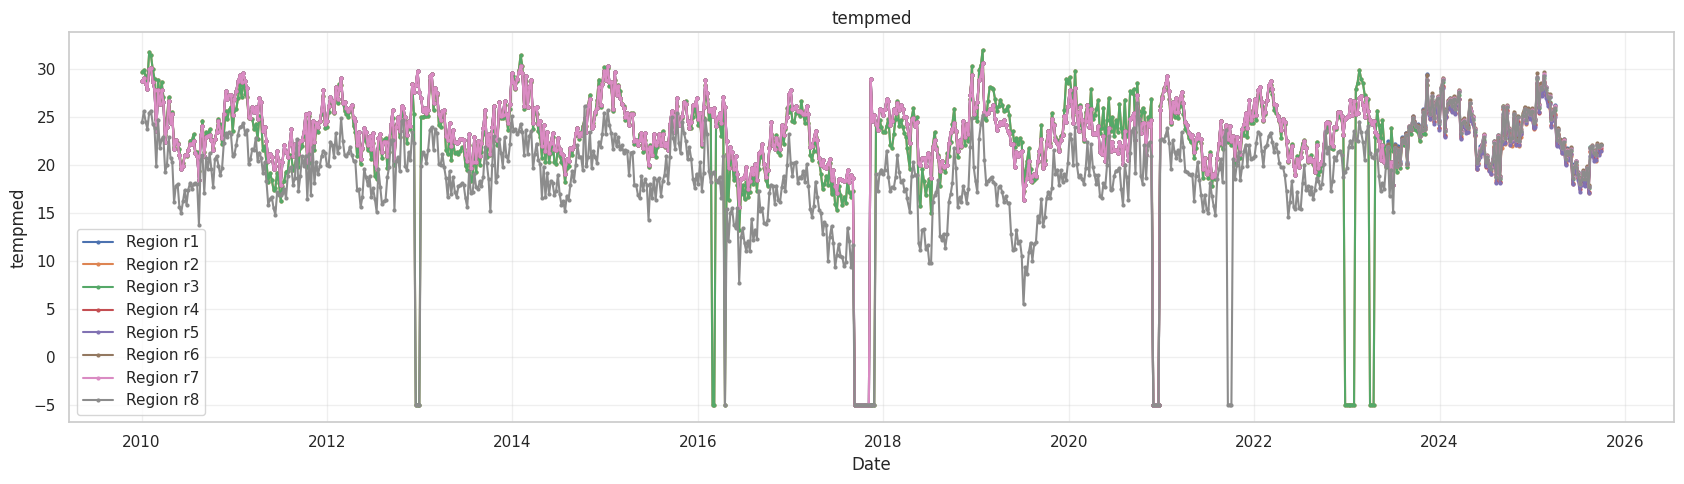

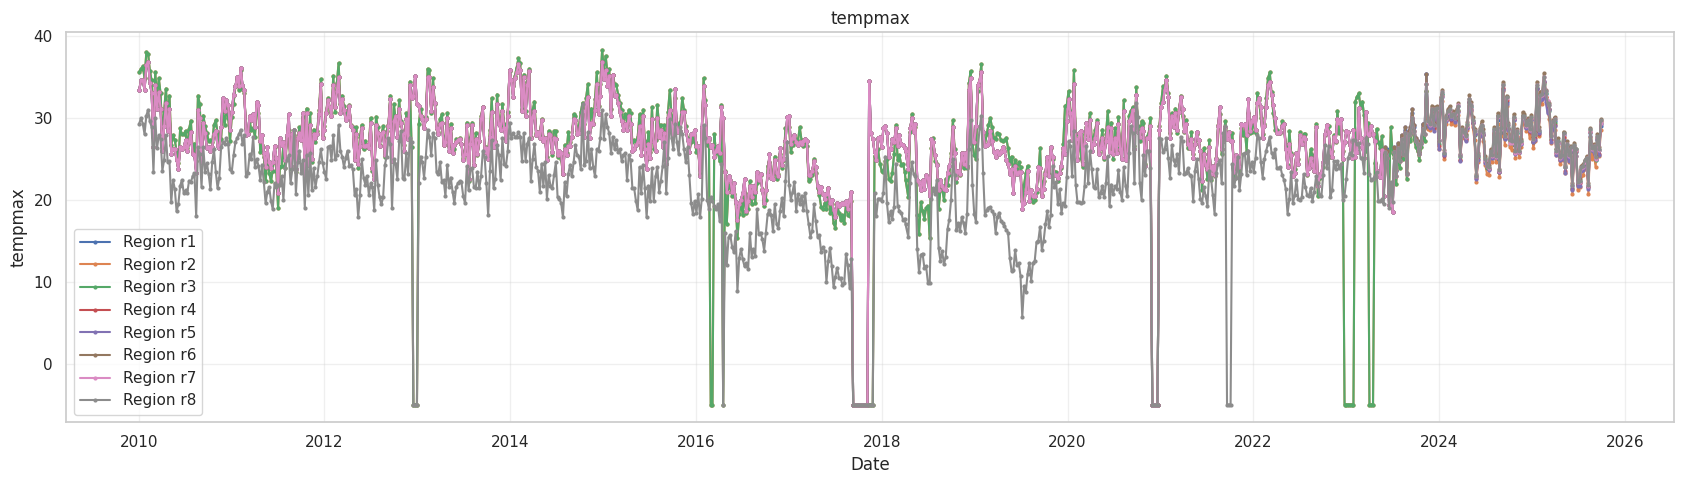

In [279]:
vars_to_plot = ['p_inc100k','tweet','tempmin','umidmax','umidmed','umidmin','tempmed','tempmax']
plot_ts(all_filt, vars_to_plot, date_col="data_iniSE", region_col="region", na_fill=-5)

In [280]:
## From the graph above, tweet data seems to exists for only the rio, therefore I will not include tweets
all_filt2 = all_filt.copy()
all_filt2.drop(columns=['tweet'], inplace=True)
all_filt2.head(5)

,data_iniSE,nivel,p_inc100k,Rt,p_rt1,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region
0,2025-09-28,1,4.663553,1.010159,0.549897,16.264375,86.827100,65.549950,41.754125,22.025125,28.983125,r1
1,2025-09-21,1,4.542814,1.022164,0.605514,18.566014,86.685729,67.339200,48.662471,21.936329,26.060614,r1
2,2025-09-14,1,4.889939,1.152180,0.959198,18.123229,92.134557,73.900929,49.199000,22.083943,27.310429,r1
3,2025-09-07,1,4.422075,1.046171,0.705604,18.081414,90.972957,74.983886,56.739414,21.020400,24.826800,r1
4,2025-08-31,1,4.195689,0.962061,0.322483,17.369214,90.180243,71.318800,48.862986,21.417529,26.341886,r1


## Baseline Model 1
Tomorrow is the same as today

In [281]:
data_b1 = all_filt2[['data_iniSE', 'nivel', 'region']].copy()
data_b1['pred'] = data_b1['nivel'].shift(-1)
data_b1 = data_b1[data_b1['data_iniSE'] != pd.to_datetime('2010-01-03')]
data_b1 = data_b1.dropna()

In [282]:
data_b1.head(5)

,data_iniSE,nivel,region,pred
0,2025-09-28,1,r1,1.0
1,2025-09-21,1,r1,1.0
2,2025-09-14,1,r1,1.0
3,2025-09-07,1,r1,1.0
4,2025-08-31,1,r1,1.0


In [283]:
def eval(y_true, y_pred, region=None):
    acc = round(accuracy_score(y_true, y_pred), 3)
    precision = round(precision_score(y_true, y_pred, average="weighted", zero_division=0), 3)
    recall = round(recall_score(y_true, y_pred, average="weighted", zero_division=0), 3)
    f1 = round(f1_score(y_true, y_pred, average="weighted", zero_division=0), 3)

    row = pd.DataFrame([{
        "region": region,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }])
    return row

In [284]:
reg = data_b1['region'].unique().tolist()
eval_baseline = pd.DataFrame()

for _, r in enumerate(reg):
    data = data_b1[data_b1['region']==r]
    eval_baseline = pd.concat([eval_baseline, eval(data['nivel'], data['pred'], r)], ignore_index=True)

In [285]:
eval_baseline

,region,accuracy,precision,recall,f1
0,r1,0.914,0.914,0.914,0.914
1,r2,0.940,0.940,0.940,0.940
2,r3,0.943,0.943,0.943,0.943
3,r4,0.894,0.894,0.894,0.894
4,r5,0.904,0.904,0.904,0.904
5,r6,0.899,0.899,0.899,0.899
6,r7,0.957,0.957,0.957,0.957
7,r8,0.971,0.971,0.971,0.971


## Data Preparation For XGBOOST

Transform the data to make the brazilian dataset to be more general (based on only incidence and weathers info) by:
- Making the pseudo Rt from the incidence cases (to be added)
- Change the nivel (alarm level) into 0/1 where 0 is flat or going down and 1 is if there is an increase in level

In [286]:
def prep(df, h=1, train_frac=0.75):
    df = df.copy()
    df['data_iniSE'] = pd.to_datetime(df['data_iniSE'])
    df = df.sort_values(['region','data_iniSE'])

    # Make nivel into binary
    df['nivel_binary'] = (df.groupby('region')['nivel'].diff().gt(0).astype(int).fillna(0)    )

    # Shift forward the niveel by h amount of horizon
    df['nivel_binary'] = df.groupby('region')['nivel_binary'].shift(-h)


    df = df.drop(columns=['Rt','p_rt1','nivel'])
    df = df.dropna()

    # Treat per region the train-test split
    regs = df['region'].unique()
    tr_parts, te_parts = [], []
    for r in regs:
        g = df[df['region']==r].copy()
        n = len(g)
        tr_end = int(np.floor(train_frac * n))
        print(f"region: {r}, total week: {n}, train until week: {tr_end}")

        g_tr = g.iloc[:tr_end].dropna(subset=['nivel_binary'])
        g_te = g.iloc[tr_end:].dropna(subset=['nivel_binary'])

        tr_parts.append(g_tr)
        te_parts.append(g_te)

    data_ml  = pd.concat(tr_parts, ignore_index=True)
    data_test = pd.concat(te_parts, ignore_index=True)
    return data_ml, data_test


In [287]:
data_ml, data_test = prep(all_filt2)
data_ml.head(5)

region: r1, total week: 808, train until week: 606
region: r2, total week: 790, train until week: 592
region: r3, total week: 790, train until week: 592
region: r4, total week: 808, train until week: 606
region: r5, total week: 808, train until week: 606
region: r6, total week: 808, train until week: 606
region: r7, total week: 808, train until week: 606
region: r8, total week: 798, train until week: 598


,data_iniSE,p_inc100k,tempmin,umidmax,umidmed,umidmin,tempmed,tempmax,region,nivel_binary
0,2010-01-03,0.444588,25.142857,89.714286,71.687877,45.857143,28.714322,33.428571,r1,0.0
1,2010-01-10,0.652063,24.428571,90.571429,68.771851,40.857143,29.021947,34.571429,r1,1.0
2,2010-01-17,0.681702,23.857143,89.285714,70.101537,37.857143,28.344092,34.571429,r1,0.0
3,2010-01-24,0.696522,23.714286,89.857143,71.274127,42.857143,27.822510,33.428571,r1,0.0
4,2010-01-31,1.007734,25.142857,84.857143,62.218228,33.571429,29.935030,36.428571,r1,0.0


Xy split

In [288]:
NON_FEAT = {"data_iniSE", "region", "nivel", "nivel_binary"}

def make_Xy(df):
    cols = [c for c in df.columns if c not in NON_FEAT]
    X = df[cols]
    y = df["nivel_binary"].astype(int)
    return X, y, cols

In [289]:
X_train_raw, y_train, feat_cols = make_Xy(data_ml)
X_test_raw = data_test.reindex(columns=feat_cols)

# Class Imbalance - SMOT-EEN Sampling

In [290]:
def plot_pie (y, title=""):
    vc = pd.Series(y).value_counts().sort_index()
    labels = [f"{cls} ({cnt}, {cnt/len(y):.1%})" for cls, cnt in vc.items()]
    plt.figure(figsize=(5,5))
    plt.pie(vc.values, labels=labels,  colors=["darkblue", "darkred"], startangle=90)
    plt.title(title)
    plt.axis("equal")
    plt.show()

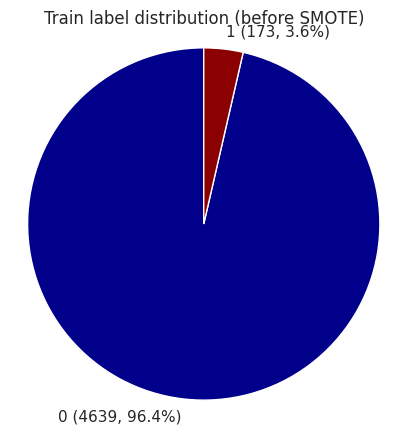

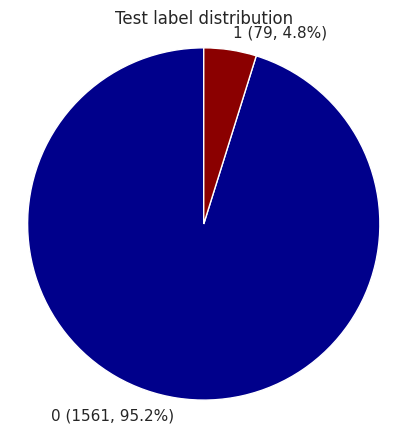

In [291]:
plot_pie(y_train, "Train label distribution (before SMOTE)")
plot_pie(y_test,  "Test label distribution")

SMOTE first selects a minority class instance a at random and finds its k nearest minority class neighbors. The synthetic instance is then created by choosing one of the k nearest neighbors b at random and connecting a and b to form a line segment in the feature space. The synthetic instances are generated as a convex combination of the two chosen instances a and b.

EEN (Edited Nearest Neighbors) is a "cleaning" mechanism.

By combining SMOTE with ENN, SMOTENN is able to generate synthetic samples that are more representative of the minority class and reduce the presence of noisy samples. This can lead to improved generalization performance of the model.

In [293]:
# SMOTE-EEN Sampling
smenn = SMOTEENN()
X_train2, y_train2 = smenn.fit_resample (X_train_raw, y_train)

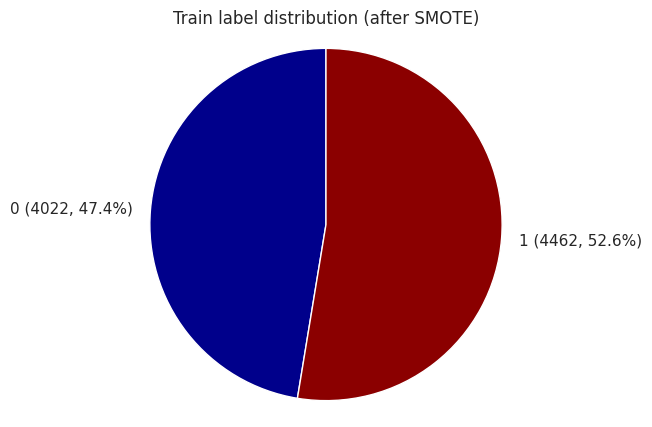

In [294]:
plot_pie(y_train2, "Train label distribution (after SMOTE)")

## XGBoost



In [306]:
model = XGBClassifier(
    objective="binary:logistic",
    eval_metric="aucpr",
    n_estimators=500,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.9,
    colsample_bytree=0.9,
    scale_pos_weight=spw,
    random_state=42,
)
model.fit(X_train2, y_train2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.03, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=500,
              n_jobs=None, num_parallel_tree=None, ...)

## Test

In [307]:
y_pred = model.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [308]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print("XGBoost Accuracy:", round(accuracy,2))
print("F1 Score:", round(f1,2))
print("Recall:", round(recall,2))
print("Precision:", round(precision,2))

XGBoost Accuracy: 0.66
F1 Score: 0.19
Recall: 0.81
Precision: 0.11


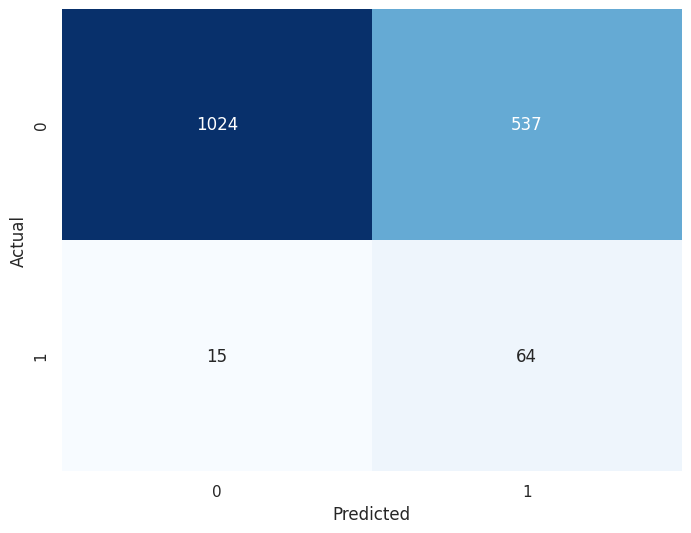

In [309]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Feature Importance

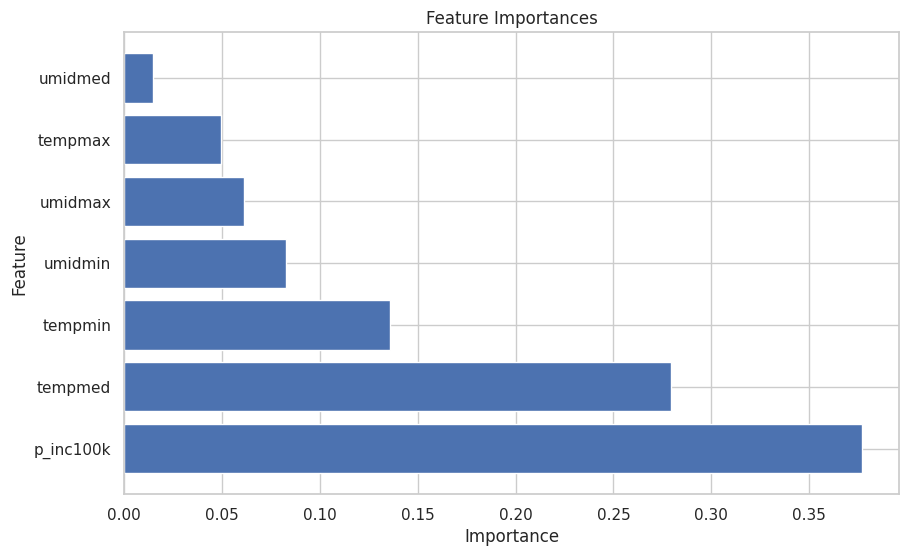

In [305]:
feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': X_train2.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_features = feature_importance_df

plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.show()